# Data Loading and Exploration

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('bank.csv', sep=';')

df.info()

df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [2]:
# Check the class distribution of the target variable 'y'
class_distribution = df['y'].value_counts(normalize=True)

print("\nClass distribution of the target variable 'y':")
print(class_distribution)


Class distribution of the target variable 'y':
y
no     0.88476
yes    0.11524
Name: proportion, dtype: float64


In [3]:
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


In [4]:
df.shape

(4521, 17)

# Data Preprocessing


In [5]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Label encode binary columns
binary_cols = ['default', 'housing', 'loan']
le = LabelEncoder()

for col in binary_cols:
    df[col] = le.fit_transform(df[col])


# One-hot encode multi-class categorical columns using pandas get_dummies
multi_cols = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']

df = pd.get_dummies(df, columns=multi_cols, drop_first=True)

# Label encode the target column y
df['y'] = le.fit_transform(df['y'])

df.head()


,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,30,0,1787,0,0,19,79,1,-1,0,...,False,False,False,False,False,True,False,False,False,True
1,33,0,4789,1,1,11,220,1,339,4,...,False,False,False,True,False,False,False,False,False,False
2,35,0,1350,1,0,16,185,1,330,1,...,False,False,False,False,False,False,False,False,False,False
3,30,0,1476,1,1,3,199,4,-1,0,...,False,True,False,False,False,False,False,False,False,True
4,59,0,0,1,0,5,226,1,-1,0,...,False,False,False,True,False,False,False,False,False,True


In [6]:
# Convert boolean columns to integer 0/1
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)
df.head()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,30,0,1787,0,0,19,79,1,-1,0,...,0,0,0,0,0,1,0,0,0,1
1,33,0,4789,1,1,11,220,1,339,4,...,0,0,0,1,0,0,0,0,0,0
2,35,0,1350,1,0,16,185,1,330,1,...,0,0,0,0,0,0,0,0,0,0
3,30,0,1476,1,1,3,199,4,-1,0,...,0,1,0,0,0,0,0,0,0,1
4,59,0,0,1,0,5,226,1,-1,0,...,0,0,0,1,0,0,0,0,0,1


In [7]:
df.shape

(4521, 43)

### Separate features and target

In [8]:
X = df.drop('y', axis=1)  # all columns except the target
y = df['y']               # target column

# Decision Tree Cross-Validation with SMOTE Pipeline

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import numpy as np

# Define pipeline: SMOTE + Decision Tree
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('dt', DecisionTreeClassifier(criterion='entropy', random_state=42))
])

# Define stratified k-fold with shuffle and fixed random seed
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation, scoring by f1 (good for imbalance)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1')

print(f"Cross-validated F1 scores: {scores}")
print(f"Mean F1 score: {np.mean(scores):.4f}")


Cross-validated F1 scores: [0.49541284 0.46846847 0.42016807 0.41904762 0.43809524 0.42592593
 0.576      0.44036697 0.43636364 0.44642857]
Mean F1 score: 0.4566


In [10]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

# Get cross-validated predictions
y_pred = cross_val_predict(pipeline, X, y, cv=cv)

# Print classification report
print("Decision Tree Classification Report:")
print(classification_report(y, y_pred))

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      4000
           1       0.43      0.49      0.46       521

    accuracy                           0.87      4521
   macro avg       0.68      0.70      0.69      4521
weighted avg       0.87      0.87      0.87      4521



# DT (No RFE): Confusion Matrix, ROC, PR, Feature Importance

In [18]:
import os
os.makedirs("assets", exist_ok=True)

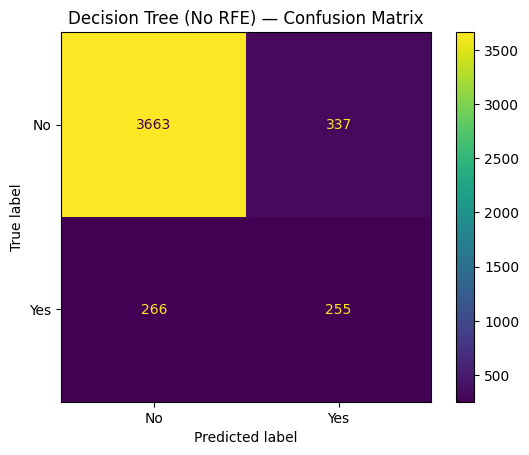

In [19]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np

# 1) Confusion matrix (cross-validated)
y_pred_dt_no = cross_val_predict(pipeline, X, y, cv=cv)
cm = confusion_matrix(y, y_pred_dt_no, labels=[0,1])
ConfusionMatrixDisplay(cm, display_labels=['No','Yes']).plot(values_format='d')
plt.title("Decision Tree (No RFE) — Confusion Matrix")
plt.savefig("assets/cm_dt_no_rfe.png", dpi=150, bbox_inches="tight");
plt.show()

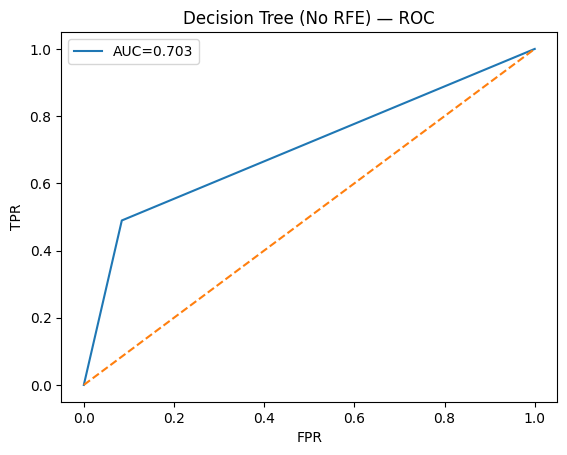

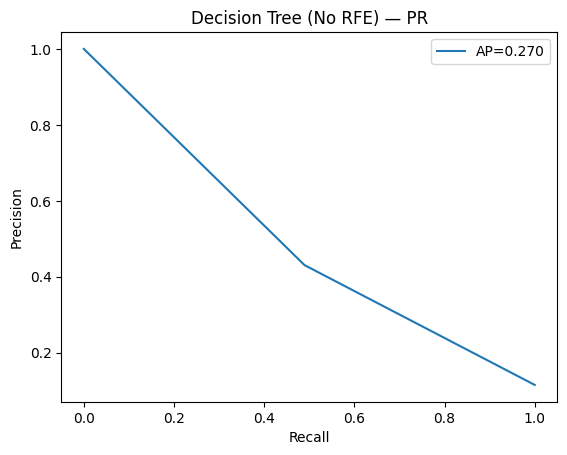

In [20]:
# 2) ROC & PR (use predict_proba)
y_scores_dt_no = cross_val_predict(pipeline, X, y, cv=cv, method="predict_proba")[:,1]
fpr, tpr, _ = roc_curve(y, y_scores_dt_no); roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}"); plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Decision Tree (No RFE) — ROC"); plt.legend()
plt.savefig("assets/roc_dt_no_rfe.png", dpi=150, bbox_inches="tight"); plt.show()

prec, rec, _ = precision_recall_curve(y, y_scores_dt_no); ap = average_precision_score(y, y_scores_dt_no)
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Decision Tree (No RFE) — PR");
plt.legend()
plt.savefig("assets/pr_dt_no_rfe.png", dpi=150, bbox_inches="tight");
plt.show()

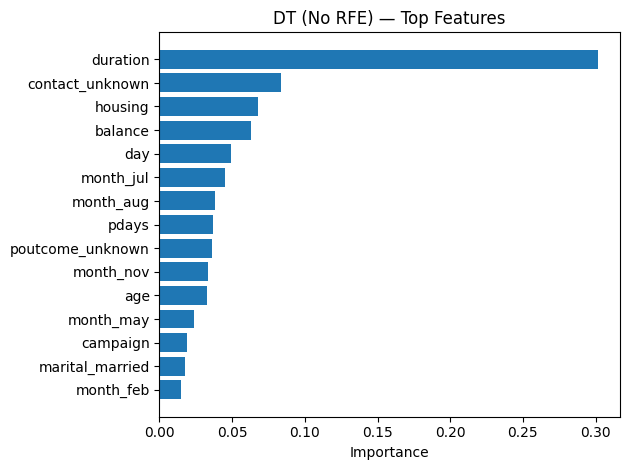

In [22]:
# 3) Feature importance
pipeline.fit(X, y)
feat_names = getattr(X, "columns", np.arange(X.shape[1]).astype(str))
imp = pipeline.named_steps['dt'].feature_importances_
order = np.argsort(imp)[::-1][:15]
plt.barh(range(len(order)), imp[order][::-1])
plt.yticks(range(len(order)), np.array(feat_names)[order][::-1])
plt.xlabel("Importance"); plt.title("DT (No RFE) — Top Features");
plt.tight_layout()
plt.savefig("assets/fi_dt_no_rfe.png", dpi=150, bbox_inches="tight");
plt.show()

# SVM Cross-Validation with SMOTE and Scaling Pipeline

In [11]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import numpy as np

# Build pipeline: SMOTE -> Scaling -> SVM
svm_pipeline_no_rfe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', random_state=42, C=1))
])

# Define stratified k-fold with shuffle and fixed random seed
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validate using F1 score (good for imbalanced)
scores = cross_val_score(svm_pipeline_no_rfe, X, y, cv=cv, scoring='f1')

print(f"Cross-validated F1 scores: {scores}")
print(f"Mean F1 score: {np.mean(scores):.4f}")


Cross-validated F1 scores: [0.48979592 0.45360825 0.4950495  0.46808511 0.43956044 0.52
 0.58585859 0.32967033 0.4        0.47524752]
Mean F1 score: 0.4657


In [12]:
# Get cross-validated predictions for classification report and confusion matrix
y_pred = cross_val_predict(svm_pipeline_no_rfe, X, y, cv=cv)

print("SVM Classification Report:")
print(classification_report(y, y_pred))

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      4000
           1       0.51      0.43      0.47       521

    accuracy                           0.89      4521
   macro avg       0.72      0.69      0.70      4521
weighted avg       0.88      0.89      0.88      4521



# SVM (No RFE): Confusion Matrix, ROC, PR, Coefficients (Linear)

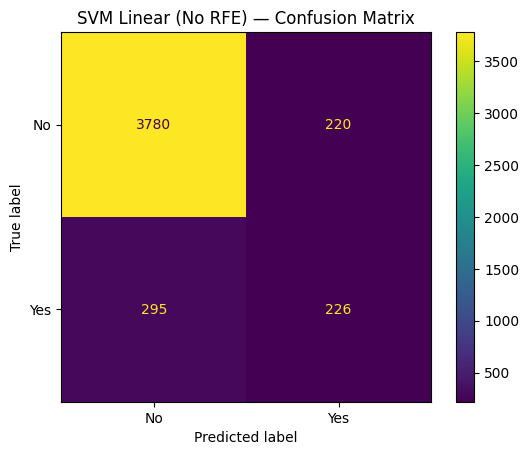

In [23]:
# 1) Confusion matrix (cross-validated)
y_pred_svm_no = cross_val_predict(svm_pipeline_no_rfe, X, y, cv=cv)
cm = confusion_matrix(y, y_pred_svm_no, labels=[0,1])
ConfusionMatrixDisplay(cm, display_labels=['No','Yes']).plot(values_format='d')
plt.title("SVM Linear (No RFE) — Confusion Matrix")
plt.savefig("assets/cm_svm_no_rfe.png", dpi=150, bbox_inches="tight");
plt.show()

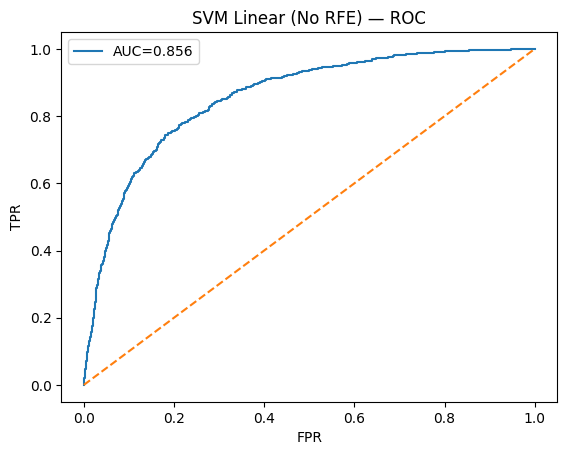

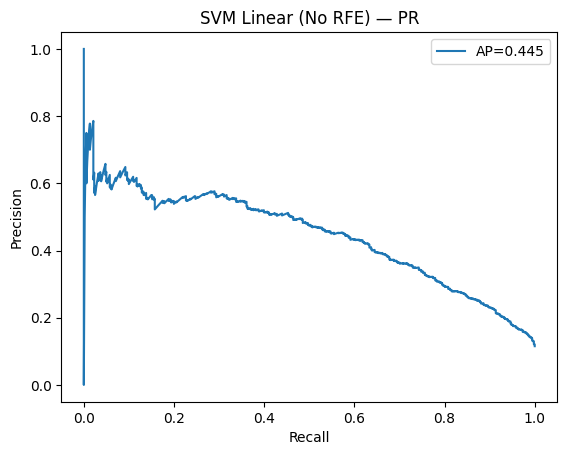

In [24]:
# 2) ROC & PR (prefer predict_proba; fallback to decision_function)
try:
    y_scores_svm_no = cross_val_predict(svm_pipeline_no_rfe, X, y, cv=cv, method="predict_proba")[:,1]
except:
    y_scores_svm_no = cross_val_predict(svm_pipeline_no_rfe, X, y, cv=cv, method="decision_function")

fpr, tpr, _ = roc_curve(y, y_scores_svm_no); roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}"); plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("SVM Linear (No RFE) — ROC"); plt.legend()
plt.savefig("assets/roc_svm_no_rfe.png", dpi=150, bbox_inches="tight"); plt.show()

prec, rec, _ = precision_recall_curve(y, y_scores_svm_no); ap = average_precision_score(y, y_scores_svm_no)
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("SVM Linear (No RFE) — PR");
plt.legend()
plt.savefig("assets/pr_svm_no_rfe.png", dpi=150, bbox_inches="tight");
plt.show()

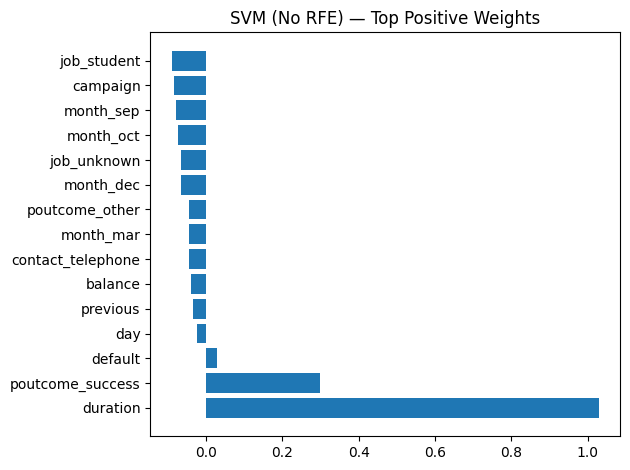

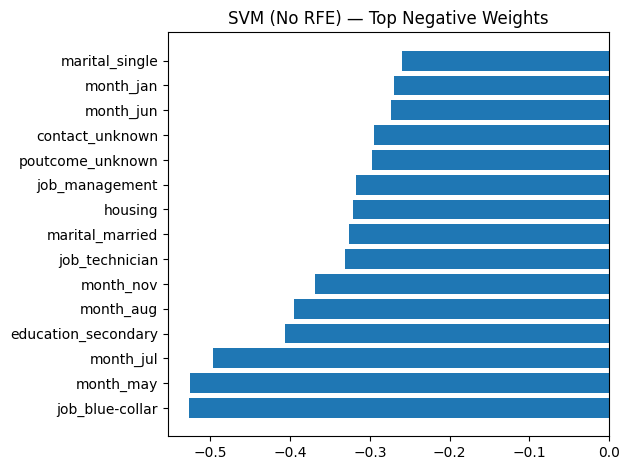

In [25]:
# 3) Linear weights
svm_pipeline_no_rfe.fit(X, y)
coef = svm_pipeline_no_rfe.named_steps['svm'].coef_.ravel()
feat_names = getattr(X, "columns", np.arange(X.shape[1]).astype(str))
top = 15
pos_idx = np.argsort(coef)[-top:]; neg_idx = np.argsort(coef)[:top]

plt.barh(range(top), coef[pos_idx][::-1])
plt.yticks(range(top), np.array(feat_names)[pos_idx][::-1])
plt.title("SVM (No RFE) — Top Positive Weights"); plt.tight_layout()
plt.savefig("assets/svm_no_rfe_pos.png", dpi=150, bbox_inches="tight");
plt.show()

plt.barh(range(top), coef[neg_idx])
plt.yticks(range(top), np.array(feat_names)[neg_idx])
plt.title("SVM (No RFE) — Top Negative Weights");
plt.tight_layout()
plt.savefig("assets/svm_no_rfe_neg.png", dpi=150, bbox_inches="tight");
plt.show()


# Next Steps: Feature Selection using Recursive Feature Elimination (RFE)

### Decision Tree with RFE

In [13]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

dt_estimator = DecisionTreeClassifier(criterion='entropy', random_state=42)

dt_pipeline_rfe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('feature_selection', RFE(estimator=dt_estimator, n_features_to_select=20)),
    ('dt', dt_estimator)
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(dt_pipeline_rfe, X, y, cv=cv, scoring='f1')

print(f"Cross-validated F1 scores with RFE: {scores}")
print(f"Mean F1 score with RFE: {np.mean(scores):.4f}")

dt_pipeline_rfe.fit(X, y)
rfe_step = dt_pipeline_rfe.named_steps['feature_selection']
selected_mask = rfe_step.support_
selected_features = X.columns[selected_mask]
print("Selected features:")
print(selected_features)

Cross-validated F1 scores with RFE: [0.55172414 0.40707965 0.41509434 0.41071429 0.41071429 0.43697479
 0.52892562 0.49090909 0.52       0.42735043]
Mean F1 score with RFE: 0.4599
Selected features:
Index(['age', 'balance', 'housing', 'day', 'duration', 'campaign', 'pdays',
       'job_blue-collar', 'job_management', 'job_technician',
       'marital_married', 'marital_single', 'education_secondary',
       'contact_unknown', 'month_aug', 'month_feb', 'month_jan', 'month_jul',
       'month_may', 'month_nov'],
      dtype='object')


In [14]:
y_pred = cross_val_predict(dt_pipeline_rfe, X, y, cv=cv)

print("Decision Tree Classification Report (With RFE):")
print(classification_report(y, y_pred))

Decision Tree Classification Report (With RFE):
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      4000
           1       0.43      0.50      0.46       521

    accuracy                           0.87      4521
   macro avg       0.68      0.71      0.69      4521
weighted avg       0.87      0.87      0.87      4521



# DT (With RFE): Confusion Matrix, ROC, PR, Feature Importance on Selected Features


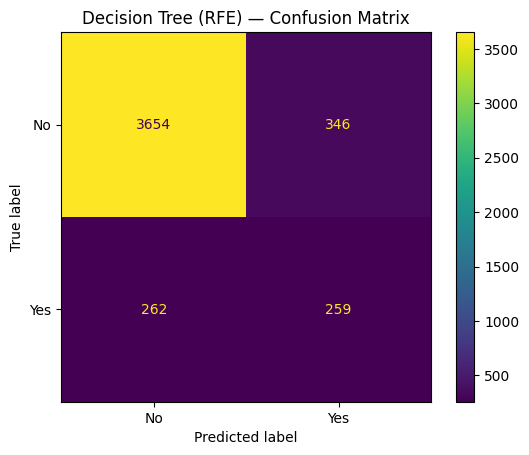

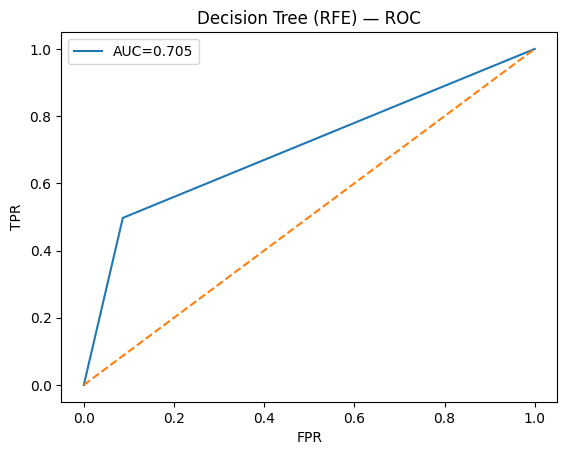

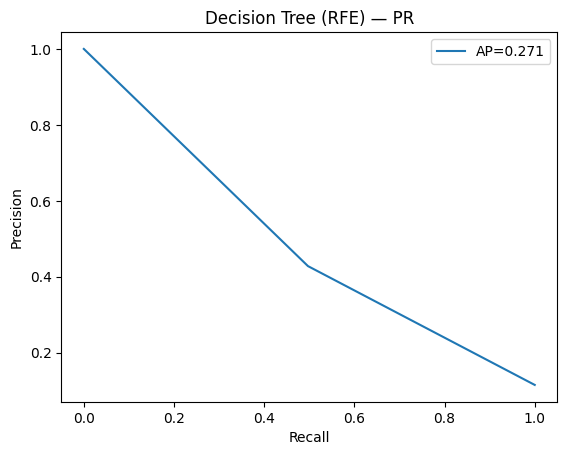

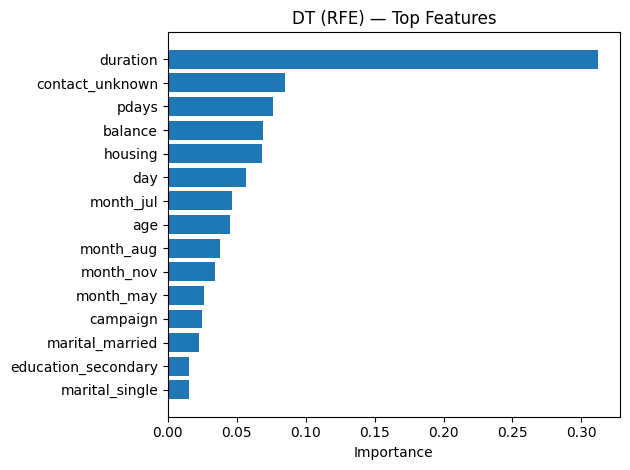

In [26]:
# 1) Confusion matrix
y_pred_dt_rfe = cross_val_predict(dt_pipeline_rfe, X, y, cv=cv)
cm = confusion_matrix(y, y_pred_dt_rfe, labels=[0,1])
ConfusionMatrixDisplay(cm, display_labels=['No','Yes']).plot(values_format='d')
plt.title("Decision Tree (RFE) — Confusion Matrix")
plt.savefig("assets/cm_dt_rfe.png", dpi=150, bbox_inches="tight");
plt.show()

# 2) ROC & PR
y_scores_dt_rfe = cross_val_predict(dt_pipeline_rfe, X, y, cv=cv, method="predict_proba")[:,1]
fpr, tpr, _ = roc_curve(y, y_scores_dt_rfe); roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}"); plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Decision Tree (RFE) — ROC"); plt.legend()
plt.savefig("assets/roc_dt_rfe.png", dpi=150, bbox_inches="tight");
plt.show()

prec, rec, _ = precision_recall_curve(y, y_scores_dt_rfe); ap = average_precision_score(y, y_scores_dt_rfe)
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Decision Tree (RFE) — PR"); plt.legend()
plt.savefig("assets/pr_dt_rfe.png", dpi=150, bbox_inches="tight");
plt.show()

# 3) Feature importance
dt_pipeline_rfe.fit(X, y)
rfe = dt_pipeline_rfe.named_steps['feature_selection']
sel_mask = rfe.support_
feat_names = getattr(X, "columns", np.arange(X.shape[1]).astype(str))[sel_mask]
imp = dt_pipeline_rfe.named_steps['dt'].feature_importances_
order = np.argsort(imp)[::-1][:15]
plt.barh(range(len(order)), imp[order][::-1])
plt.yticks(range(len(order)), np.array(feat_names)[order][::-1])
plt.xlabel("Importance"); plt.title("DT (RFE) — Top Features");
plt.tight_layout()
plt.savefig("assets/fi_dt_rfe.png", dpi=150, bbox_inches="tight");
plt.show()


### SVM with RFE

In [15]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

svm_estimator = SVC(kernel='linear', random_state=42, C=1)

svm_pipeline_rfe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('feature_selection', RFE(estimator=dt_estimator, n_features_to_select=20)),
    ('scaler', StandardScaler()),
    ('svm', svm_estimator)
])

scores_svm = cross_val_score(svm_pipeline_rfe, X, y, cv=cv, scoring='f1')

print(f"Cross-validated F1 scores with RFE (SVM): {scores_svm}")
print(f"Mean F1 score with RFE (SVM): {np.mean(scores_svm):.4f}")

svm_pipeline_rfe.fit(X, y)
rfe_step_svm = svm_pipeline_rfe.named_steps['feature_selection']
selected_mask_svm = rfe_step_svm.support_
selected_features_svm = X.columns[selected_mask_svm]
print("Selected features:")
print(selected_features_svm)

Cross-validated F1 scores with RFE (SVM): [0.49122807 0.41071429 0.50847458 0.46551724 0.44247788 0.48739496
 0.50406504 0.44859813 0.43636364 0.54385965]
Mean F1 score with RFE (SVM): 0.4739
Selected features:
Index(['age', 'balance', 'housing', 'day', 'duration', 'campaign', 'pdays',
       'job_blue-collar', 'job_management', 'job_technician',
       'marital_married', 'marital_single', 'education_secondary',
       'contact_unknown', 'month_aug', 'month_feb', 'month_jan', 'month_jul',
       'month_may', 'month_nov'],
      dtype='object')


In [16]:
y_pred_svm = cross_val_predict(svm_pipeline_rfe, X, y, cv=cv)

print("SVM Classification Report (With RFE):")
print(classification_report(y, y_pred_svm))

SVM Classification Report (With RFE):
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      4000
           1       0.44      0.52      0.47       521

    accuracy                           0.87      4521
   macro avg       0.69      0.72      0.70      4521
weighted avg       0.88      0.87      0.87      4521



# SVM (With RFE): Confusion Matrix, ROC, PR, Linear Weights on Selected Features

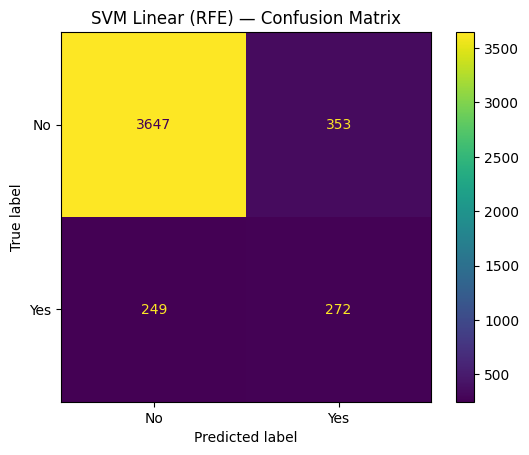

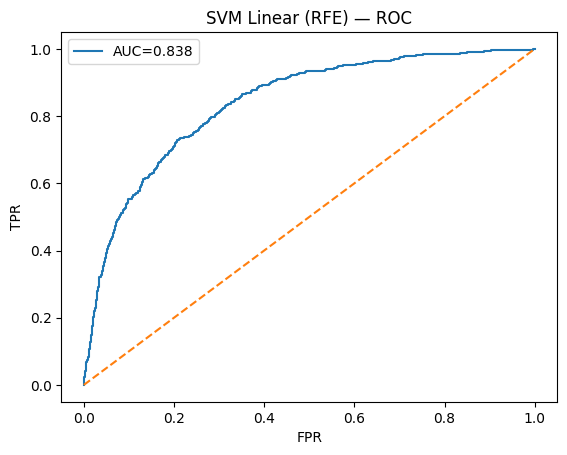

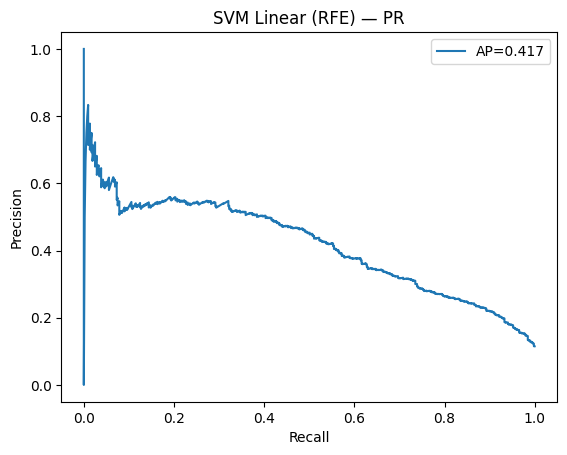

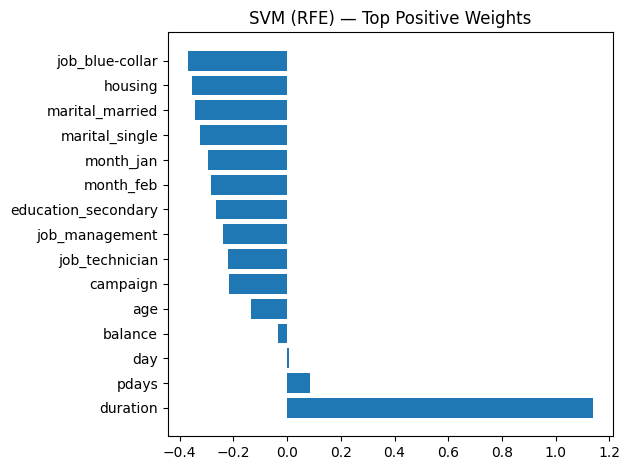

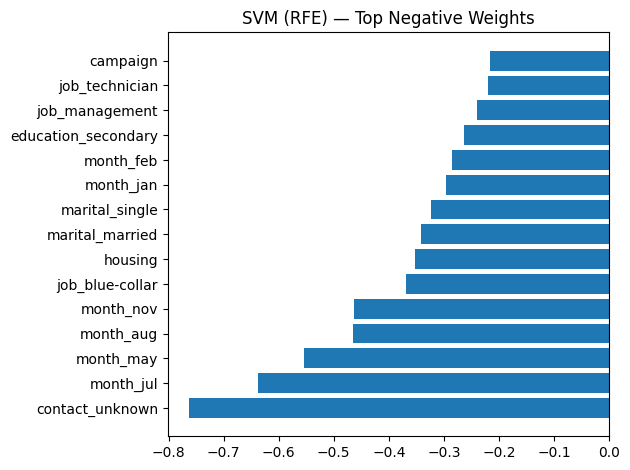

In [27]:
# 1) Confusion matrix
y_pred_svm_rfe = cross_val_predict(svm_pipeline_rfe, X, y, cv=cv)
cm = confusion_matrix(y, y_pred_svm_rfe, labels=[0,1])
ConfusionMatrixDisplay(cm, display_labels=['No','Yes']).plot(values_format='d')
plt.title("SVM Linear (RFE) — Confusion Matrix")
plt.savefig("assets/cm_svm_rfe.png", dpi=150, bbox_inches="tight"); plt.show()

# 2) ROC & PR (predict_proba expected for RFE SVM)
try:
    y_scores_svm_rfe = cross_val_predict(svm_pipeline_rfe, X, y, cv=cv, method="predict_proba")[:,1]
except:
    y_scores_svm_rfe = cross_val_predict(svm_pipeline_rfe, X, y, cv=cv, method="decision_function")
fpr, tpr, _ = roc_curve(y, y_scores_svm_rfe); roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}"); plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("SVM Linear (RFE) — ROC"); plt.legend()
plt.savefig("assets/roc_svm_rfe.png", dpi=150, bbox_inches="tight");
plt.show()

prec, rec, _ = precision_recall_curve(y, y_scores_svm_rfe); ap = average_precision_score(y, y_scores_svm_rfe)
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("SVM Linear (RFE) — PR"); plt.legend()
plt.savefig("assets/pr_svm_rfe.png", dpi=150, bbox_inches="tight");
plt.show()

# 3) Linear weights (selected features only)
svm_pipeline_rfe.fit(X, y)
coef = svm_pipeline_rfe.named_steps['svm'].coef_.ravel()
rfe = svm_pipeline_rfe.named_steps['feature_selection']
sel_mask = rfe.support_
feat_names = getattr(X, "columns", np.arange(X.shape[1]).astype(str))[sel_mask]

top = 15
pos_idx = np.argsort(coef)[-top:]; neg_idx = np.argsort(coef)[:top]

plt.barh(range(top), coef[pos_idx][::-1])
plt.yticks(range(top), np.array(feat_names)[pos_idx][::-1])
plt.title("SVM (RFE) — Top Positive Weights"); plt.tight_layout()
plt.savefig("assets/svm_rfe_pos.png", dpi=150, bbox_inches="tight");
plt.show()

plt.barh(range(top), coef[neg_idx])
plt.yticks(range(top), np.array(feat_names)[neg_idx])
plt.title("SVM (RFE) — Top Negative Weights"); plt.tight_layout()
plt.savefig("assets/svm_rfe_neg.png", dpi=150, bbox_inches="tight");
plt.show()